In [ ]:
#!pip install torch
#!pip install pandas
!pip install torchmetrics
!pip install tensorly
!pip install scikit-learn
!pip install rarfile
!apt-get install unrar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchmetrics import F1Score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, Subset

import pandas as pd
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
import math

from os import pread
import rarfile
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt

save_path = [
    '/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/decomp_savepoint.pth.tar',
    '/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/decomp3_savepoint.pth.tar',
    '/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/decomp5_savepoint.pth.tar'
    ]

rar_drive_path = [
    '/content/drive/MyDrive/imagens_aumentadas/9aug_bin.rar',
    '/content/drive/MyDrive/imagens_aumentadas/Originais.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/ED.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/KL.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/Li.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/Perez-Bueno.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/Renyi.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/Tosta.rar',
    '/content/drive/MyDrive/imagens_aumentadas/ref2/Vahadane.rar'
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
saving_complete_path = '/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/model_savepoint.pth.tar'
saving_decomposed_path = save_path[2]
current_drive_path = rar_drive_path[0]
rank = 0.5
print(device)




cuda


#Criando funções e classes auxiliares

##Classe para carregar o dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mapper usado nesta execução: {'healthy': 0, 'severe': 1}
Mapper usado nesta execução: {'healthy': 0, 'severe': 1}
Mapper usado nesta execução: {'healthy': 0, 'severe': 1}
Train: 1580 | Val: 22 | Test: 48


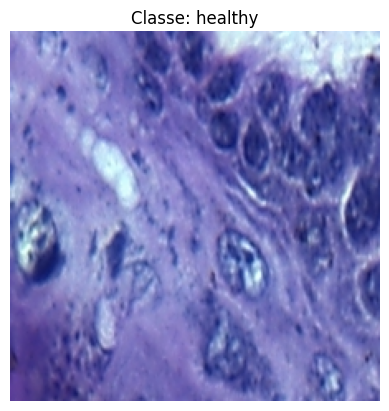

In [ ]:
# Definir a classe RarDataset
class RarDataset(Dataset):
    def __init__(self, rar_path, subset='train', transform=None, class_order=None):
        self.rar_path = rar_path
        self.transform = transform
        self.subset = subset
        self.rar_file = rarfile.RarFile(rar_path)

        self.image_files = [
            f for f in self.rar_file.namelist()
            if f.startswith(f'sem_aumento/{subset}/') and f.endswith(('png', 'jpg', 'jpeg', 'tif'))
        ]

        self.labels = [f.split('/')[2] for f in self.image_files]  # Usar o nome da pasta como label

        if class_order is None:
            #class_order = ['healthy', 'mild', 'moderate', 'severe']
            class_order = ['healthy', 'severe']

        self.mapper = {label: idx for idx, label in enumerate(class_order)}
        print("Mapper usado nesta execução:", self.mapper)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        with self.rar_file.open(img_path) as file:
            img = Image.open(BytesIO(file.read())).convert('RGB')

        # Aplicar as transformações (resize, grayscale, etc)
        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, self.mapper[label]

# Transformações para as imagens
transform = transforms.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.RGB(),
])

# Carregar o dataset diretamente do .rar
#class_order = ['healthy', 'mild', 'moderate', 'severe']
class_order = ['healthy', 'severe']
train_dataset = RarDataset(current_drive_path, subset='train', transform=transform, class_order=class_order)
val_dataset = RarDataset(current_drive_path, subset='val', transform=transform, class_order=class_order)
test_dataset = RarDataset(current_drive_path, subset='test', transform=transform, class_order=class_order)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Verifique algumas classes e tamanhos
print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}')

# Visualizar uma imagem
img, label = train_dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Classe: {class_order[label]}')
plt.axis('off')
plt.show()


##Tucker Decomposition

In [ ]:
#A classe TuckerConv2d recebe uma camada convolucional, decompoe o kernel usando tucker
#e cria convoluções na sequência para cada fator decomposto

class TuckerConv2d(torch.nn.Module):
  def __init__(self, layer, rank):
    super(TuckerConv2d, self).__init__()

    initial_tensor = layer.weight
    print(f'Shape antes: {initial_tensor.shape}')
    modes = [0,1]
    ranks = [math.ceil(layer.weight.size(0)*rank), math.ceil(layer.weight.size(1)*rank)]
    print(f'Ranks: {ranks}')

    (core_factors), _ = tl.decomposition.partial_tucker(initial_tensor.detach().numpy(), modes=modes, rank=ranks)
    (core, factors) = core_factors
    last, first = factors[0], factors[1]

    print(f'Shape de fator first: {first.shape}')
    print(f'Shape de fator last: {last.shape}')
    print(f'Shape de core: {core.shape}\n\n')

    c1 = torch.nn.Conv2d(in_channels=first.shape[0], out_channels=first.shape[1], kernel_size=(1,1), stride=(1,1), padding=0, bias=False)
    core_conv = torch.nn.Conv2d(in_channels=core.shape[1], out_channels=core.shape[0], kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding,bias=False)
    c2 = torch.nn.Conv2d(in_channels=last.shape[1], out_channels=last.shape[0], kernel_size=(1,1), stride=(1,1), padding=0, bias=True)

    c1.weight.data = torch.transpose(torch.from_numpy(first), 1, 0).unsqueeze(-1).unsqueeze(-1) #"deitando" o tensor, removendo dimensões inutilizadas e adiciona à camada.
    c2.weight.data = torch.from_numpy(last).unsqueeze(-1).unsqueeze(-1) #removendo dimensões inutilizadas e e adiciona à camada.
    core_conv.weight.data = torch.from_numpy(core) #adicionando a camada

    self.sequencial = torch.nn.Sequential(
        c1,
        core_conv,
        c2
    )

  def forward(self, x):
    return self.sequencial(x)

##Funções para salvar/carregar modelos

In [ ]:
#Funções para salvar o modelo
def saveTraining(savepoint, filePath='/content/drive/MyDrive/ref-2/savepoints/model_savepoint.pth.tar'):
    print("Saving checkpoint")
    torch.save(savepoint, filePath)

def loadTraining(savepoint):
    print("Loading Training")
    model.load_state_dict(savepoint['statedict'])
    optimizer.load_state_dict(savepoint['optim'])
    best_accuracy = savepoint['last_accuracy']
    print(f'Last training accuracy: {best_accuracy}')

#Função para cálculo de acurácia
def check_accuracy(model, loader):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      scores = model(x)
      _, predictions = scores.max(1) #A classe com maior score é a prevista pelo modelo, aqui coletamos o indice dela
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

    accuracy = round((float(num_correct)/float(num_samples)*100),2)
    print(f'Num correct: {num_correct} \nNum samples: {num_samples} \nAcurracy: {float(num_correct)/float(num_samples)*100:.2f}')
  model.train()
  return accuracy

def check_F1Score(model, loader):
  f1 = F1Score(task="multiclass", num_classes=4, average='macro')
  f1.to(device)

  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in loader:
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)
          preds = torch.argmax(outputs, dim=1)

          all_preds.append(preds)
          all_labels.append(labels)


  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

  f1_score = f1(all_preds, all_labels)
  print(f'F1 Score Macro: {f1_score.item()*100:.2f}')
  return f1_score.item()

#Criando o modelo

In [ ]:
model = torchvision.models.resnet18(weights='DEFAULT').to(device)

print(f'Parametros iniciais: {sum(np.prod(p.size()) for p in model.parameters())}')


Parametros iniciais: 11689512


#Usando a rede sem decompor

##Visualização das camadas

In [ ]:
for name, layer in model.named_modules():
  print(f'Name: {name}, Layer: {layer}')


Name: , Layer: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

##Treinamento

In [ ]:
load_last_model = True

if load_last_model:
    loadTraining(torch.load('/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/model_savepoint.pth.tar', map_location=torch.device('cpu'))) # Added map_location




Loading Training
Last training accuracy: 90.91


In [ ]:
#Substituindo a camada final para ter apenas 2 saidas
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=2).to(device)

#Definindo perda e optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

#Novos testes
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Early Stopping Setup
best_loss = float('inf')
early_stopping_patience = 5

print(f'Parametros iniciais apos substituições: {sum(np.prod(p.size()) for p in model.parameters())}')

Parametros iniciais apos substituições: 11177538


In [ ]:
epochs = 50
early_stop = False
epochs_no_improve = 0

acc_train = []
acc_val = []
model.train()
model.to(device)

for epoch in range(epochs):
  if early_stop:
        print("Early stopping ativado.")
        break

  running_loss = 0.0
  for batch, (data, targets) in enumerate(train_loader):
    data, targets = data.to(device), targets.to(device)

    pred = model(data)
    loss = loss_fn(pred,targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Validação
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for data, targets in val_loader:
          data, targets = data.to(device), targets.to(device)
          outputs = model(data)
          loss = loss_fn(outputs, targets)
          val_loss += loss.item()
  val_loss /= len(val_loader)

  print(f"Época {epoch+1} | Val Loss: {val_loss:.4f}")

  # Redução do lr se necessário
  scheduler.step(val_loss)

  train_accuracy = check_accuracy(model, train_loader)
  train_F1Score = check_F1Score(model, train_loader)
  acc_train.append(train_accuracy)

  last_accuracy = check_accuracy(model, val_loader)
  last_F1Score = check_F1Score(model, val_loader)
  acc_val.append(last_accuracy)

  # Early stopping
  if val_loss < best_loss:
      best_loss = val_loss
      epochs_no_improve = 0

      # Salvar modelo com melhor validação
      savepoint = {
          'statedict': model.state_dict(),
          'optim': optimizer.state_dict(),
          'last_accuracy': last_accuracy,
          'last_F1Score': last_F1Score
      }

      saveTraining(savepoint, filePath='/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/model_savepoint.pth.tar')

  else:
      epochs_no_improve += 1
      if epochs_no_improve >= early_stopping_patience:
          early_stop = True

  print("")
  model.train()

Época 1 | Val Loss: 0.3986
Num correct: 1428 
Num samples: 1580 
Acurracy: 90.38
F1 Score Macro: 90.38
Num correct: 18 
Num samples: 22 
Acurracy: 81.82
F1 Score Macro: 81.67
Saving checkpoint

Época 2 | Val Loss: 0.2152
Num correct: 1579 
Num samples: 1580 
Acurracy: 99.94
F1 Score Macro: 99.94
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91
Saving checkpoint

Época 3 | Val Loss: 0.2199
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91

Época 4 | Val Loss: 0.2352
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91

Época 5 | Val Loss: 0.2361
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91

Época 6 | Val Loss: 0.2336
Num correct: 1580 
Num samples: 1580 
Acurracy: 100

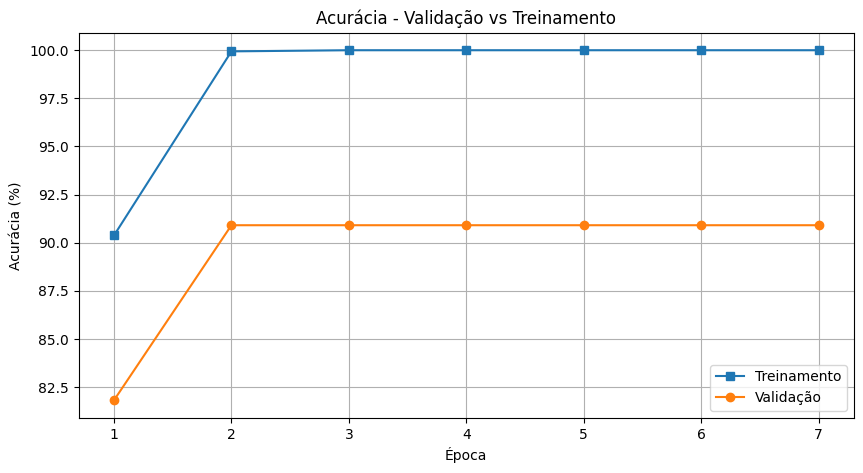

In [ ]:
epochs = np.arange(1, len(acc_val) + 1)

# Primeiro gráfico: Acurácia validação vs treinamento
plt.figure(figsize=(10,5))
plt.plot(epochs, acc_train, label='Treinamento', marker='s')
plt.plot(epochs, acc_val, label='Validação', marker='o')
plt.title('Acurácia - Validação vs Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()

##Validação

In [ ]:
last_accuracy = check_accuracy(model, val_loader)
last_F1Score = check_F1Score(model, val_loader)

savepoint = {
    'statedict': model.state_dict(),
    'optim': optimizer.state_dict(),
    'last_accuracy': last_accuracy,
    'last_F1Score': last_F1Score
}

Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91


In [ ]:
saveTraining(savepoint, filePath='/content/drive/MyDrive/imagens_aumentadas/savepoints/Originais/model_savepoint.pth.tar')

Saving checkpoint


##Teste

In [ ]:
last_accuracy = check_accuracy(model, test_loader)
last_F1Score = check_F1Score(model, test_loader)

savepoint = {
    'statedict': model.state_dict(),
    'optim': optimizer.state_dict(),
    'last_accuracy': last_accuracy,
    'last_F1Score': last_F1Score
}

Num correct: 48 
Num samples: 48 
Acurracy: 100.00
F1 Score Macro: 100.00


#Modelando a decomposição

In [ ]:
def replace_module(model, name, new_layer):
    # Divide o nome em partes, caso seja aninhado (ex: layer1.0.conv1)
    names = name.split('.')
    module = model
    for n in names[:-1]:  # Vai até o penúltimo nível
        module = module._modules[n]
    # Substitui o módulo final
    module._modules[names[-1]] = new_layer


names = []
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Conv1d):
    print(f'Name: {name}, Layer: {layer}')
    param_name = name + '.weight'
    names.append((name, layer))
print(f'Total de camadas convolucionais: {len(names)}')


for name, layer in names:
   if isinstance(layer, (torch.nn.Conv2d, torch.nn.Conv1d)) and layer.weight.size(1) != 1:
     #print(f'Name: {name}   Model: {layer}')
     new_layer = TuckerConv2d(layer.cpu(), rank).to(device)
     try:
        replace_module(model, name, new_layer)
     except Exception as e:
        print(f'Erro ao substituir a camada {name}: {e}')

print(f'Parametros finais: {sum(np.prod(p.size()) for p in model.parameters())}')



Name: conv1, Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Name: layer1.0.conv1, Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer1.0.conv2, Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer1.1.conv1, Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer1.1.conv2, Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer2.0.conv1, Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Name: layer2.0.conv2, Layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer2.0.downsample.0, Layer: Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Name: layer2.1.conv1, Layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: layer2.1.conv2, Layer: Conv2d(128, 128, kern

#Ajustes na rede decomposta

In [ ]:
load_last_model = True

if load_last_model:
    loadTraining(torch.load(saving_decomposed_path, map_location=torch.device('cpu')))


Loading Training
Last training accuracy: 90.91


In [ ]:
#Definindo perda e optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

#Novos testes
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Early Stopping Setup
best_loss = float('inf')
early_stopping_patience = 5

print(f'Parametros iniciais apos substituições: {sum(np.prod(p.size()) for p in model.parameters())}')

Parametros iniciais apos substituições: 4288648


#Treinamento na rede decomposta

In [ ]:
epochs = 50
early_stop = False
epochs_no_improve = 0

acc_train = []
acc_val = []
model.train()
model.to(device)

for epoch in range(epochs):
  if early_stop:
        print("Early stopping ativado.")
        break

  running_loss = 0.0
  for batch, (data, targets) in enumerate(train_loader):
    data, targets = data.to(device), targets.to(device)

    pred = model(data)
    loss = loss_fn(pred,targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Validação
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for data, targets in val_loader:
          data, targets = data.to(device), targets.to(device)
          outputs = model(data)
          loss = loss_fn(outputs, targets)
          val_loss += loss.item()
  val_loss /= len(val_loader)

  print(f"Época {epoch+1} | Val Loss: {val_loss:.4f}")

  # Redução do lr se necessário
  scheduler.step(val_loss)

  train_accuracy = check_accuracy(model, train_loader)
  train_F1Score = check_F1Score(model, train_loader)
  acc_train.append(train_accuracy)

  last_accuracy = check_accuracy(model, val_loader)
  last_F1Score = check_F1Score(model, val_loader)
  acc_val.append(last_accuracy)

  # Early stopping
  if val_loss < best_loss:
      best_loss = val_loss
      epochs_no_improve = 0

      # Salvar modelo com melhor validação
      savepoint = {
          'statedict': model.state_dict(),
          'optim': optimizer.state_dict(),
          'last_accuracy': last_accuracy,
          'last_F1Score': last_F1Score
      }

      saveTraining(savepoint, filePath=saving_decomposed_path)

  else:
      epochs_no_improve += 1
      if epochs_no_improve >= early_stopping_patience:
          early_stop = True

  print("")
  model.train()

Época 1 | Val Loss: 0.1345
Num correct: 1568 
Num samples: 1580 
Acurracy: 99.24
F1 Score Macro: 99.24
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91
Saving checkpoint

Época 2 | Val Loss: 0.1438
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 21 
Num samples: 22 
Acurracy: 95.45
F1 Score Macro: 95.45

Época 3 | Val Loss: 0.0992
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91
Saving checkpoint

Época 4 | Val Loss: 0.1105
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91

Época 5 | Val Loss: 0.1045
Num correct: 1580 
Num samples: 1580 
Acurracy: 100.00
F1 Score Macro: 100.00
Num correct: 21 
Num samples: 22 
Acurracy: 95.45
F1 Score Macro: 95.45

Época 6 | Val Loss: 0.1020
Num correct: 1580 
Num samples: 1580 
Acurracy: 1

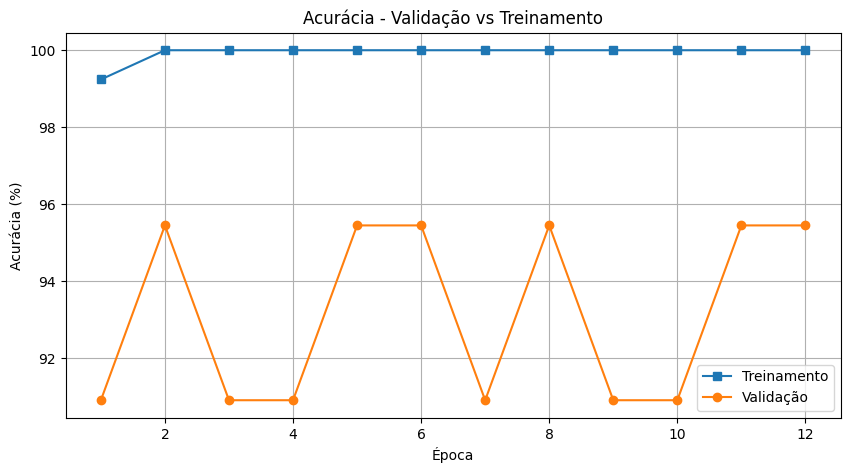

In [ ]:
epochs = np.arange(1, len(acc_val) + 1)

# Primeiro gráfico: Acurácia validação vs treinamento
plt.figure(figsize=(10,5))
plt.plot(epochs, acc_train, label='Treinamento', marker='s')
plt.plot(epochs, acc_val, label='Validação', marker='o')
plt.title('Acurácia - Validação vs Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()

#Validação

In [ ]:
last_accuracy = check_accuracy(model, val_loader)
last_F1Score = check_F1Score(model, val_loader)

savepoint = {
    'statedict': model.state_dict(),
    'optim': optimizer.state_dict(),
    'last_accuracy': last_accuracy,
    'last_F1Score': last_F1Score
}



Num correct: 20 
Num samples: 22 
Acurracy: 90.91
F1 Score Macro: 90.91


In [ ]:
saveTraining(savepoint, filePath= saving_decomposed_path)

Saving checkpoint


#Teste

In [ ]:
last_accuracy = check_accuracy(model, test_loader)
last_F1Score = check_F1Score(model, test_loader)

savepoint = {
    'statedict': model.state_dict(),
    'optim': optimizer.state_dict(),
    'last_accuracy': last_accuracy,
    'last_F1Score': last_F1Score
}

Num correct: 48 
Num samples: 48 
Acurracy: 100.00
F1 Score Macro: 100.00


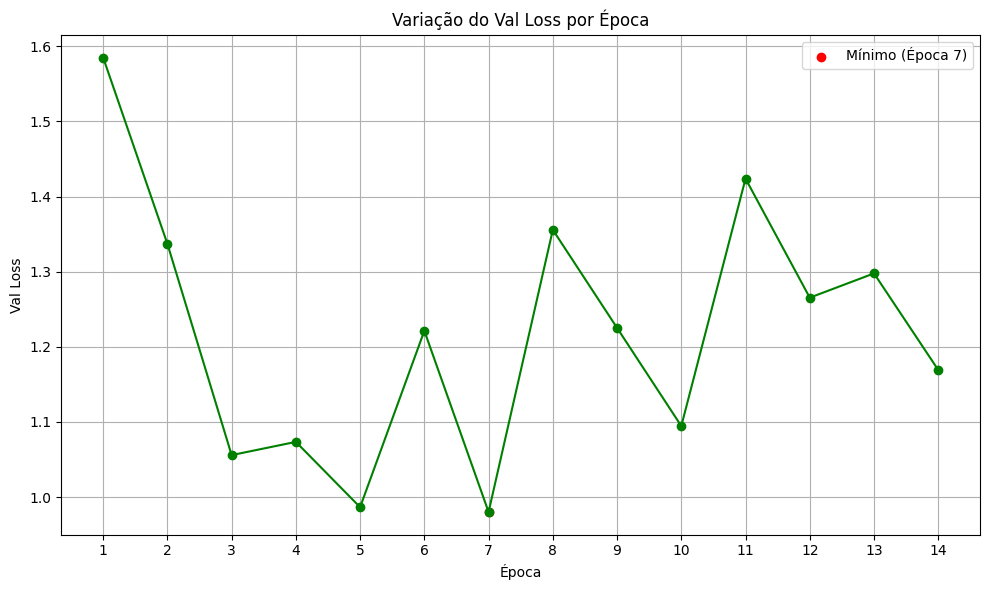

In [ ]:
val_loss = [
    1.5849, 1.3370, 1.0559, 1.0735, 0.9866,
    1.2213, 0.9802, 1.3557, 1.2252, 1.0946,
    1.4237, 1.2654, 1.2977, 1.1692
]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', linestyle='-', color='green')

# Adicionar destaque para o menor val_loss
min_idx = val_loss.index(min(val_loss)) + 1
plt.scatter(min_idx, min(val_loss), color='red', label=f'Mínimo (Época {min_idx})')

# Adicionar títulos e rótulos
plt.title('Variação do Val Loss por Época')
plt.xlabel('Época')
plt.ylabel('Val Loss')
plt.grid(True)
plt.xticks(range(1, len(val_loss) + 1))
plt.legend()
plt.tight_layout()

# Exibir o gráfico
plt.show()